<a href="https://colab.research.google.com/github/MrVereshchak/Cloud-Height-Prediction-WA/blob/main/Cloud_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cloud Base Height Nowcast in Washington State Using Deep Learning

Developed by Darii Vereshchak

LinkedIn: https://www.linkedin.com/in/darii-vereshchak/

I have developed a deep learning model to predict the height of clouds in Washington State. The focus of this model is to provide accurate predictions for the upcoming hour, based on 6 hours of historical data.

The data was collected hourly in NetCDF format and gridded by 0.25x0.25 degrees (27x27 km) by the European Centre for Medium-Range Weather [1]. Elevation data was collected from open sources [2].

The dataset ranges from 2018 to 2023 and contains 11 features: Cloud Base Height, Low Cloud Cover, Total Cloud Cover, 10m u-component of Wind, 10m v-component of Wind, 2m Temperature, Total Precipitation, Surface Net Solar Radiation, Mean sea level pressure, Surface pressure, and Elevation.

I sequenced and normalized the data before using the long short-term memory (LSTM) model as a baseline and then Convolutional LSTM (ConvLSTM).

To assess model performance, I visually compared it with the ground truth [3] and used the mean absolute error (MAE) to determine the average error for each cell in meters. The current best model has an MAE of 818.9, and the project is still ongoing.



[1] European Centre for Medium-Range Weather dataset:

https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

[2] Elevation dataset:

http://research.jisao.washington.edu/data_sets/elevation/

[3] Visual results:

https://www.figma.com/file/Y6lW9LJ9CjJbfnvbfKJUka/Cloud_project?type=design&node-id=0%3A1&mode=design&t=H6qGNtS56ROs9Kmk-1

# The code

### Import and install libraries


In [ ]:
%pip install basemap
%pip install zarr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.8/935.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 31.0 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.9 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=474b10b0b917866b3c038029f61eb8c23877c3acae2a45855404f23de0dc287a
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from mpl_toolkits.basemap import Basemap

### Downloading and cleaning data


In [ ]:
# read netcdf files 2018-2023
datasets = {}
for year in range(2018, 2024):
    datasets[f'Y{year}'] = xr.open_dataset(f'/content/drive/MyDrive/Cloud_data/{year}.nc')

datasets['Y2018']

<xarray.Dataset>
Dimensions:    (longitude: 37, latitude: 17, time: 8760)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -116.5 -116.2 -116.0
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 45.5 45.25 45.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    cbh        (time, latitude, longitude) float32 ...
    lcc        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    ssr        (time, latitude, longitude) float32 ...
    sp         (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 02:12:55 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
# check dimentions
for year in range(2018, 2024):
    print(datasets[f'Y{year}'].sizes)

Frozen({'longitude': 37, 'latitude': 17, 'time': 8760})
Frozen({'longitude': 37, 'latitude': 17, 'time': 8760})
Frozen({'longitude': 37, 'latitude': 17, 'time': 8784})
Frozen({'longitude': 37, 'latitude': 17, 'time': 8760})
Frozen({'longitude': 37, 'latitude': 17, 'time': 8760})
Frozen({'longitude': 37, 'latitude': 17, 'expver': 2, 'time': 7927})


In [ ]:
# check if any values in arrays are nan
for year in range(2018, 2024):
    print(np.any(np.isnan(datasets[f'Y{year}'])))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    u10      bool False
    v10      bool False
    t2m      bool False
    cbh      bool True
    lcc      bool False
    msl      bool False
    ssr      bool False
    sp       bool False
    tcc      bool False
    tp       bool False
<xarray.Dataset>
Dimensions:  ()
Data variables:
    u10      bool False
    v10      bool False
    t2m      bool False
    cbh      bool True
    lcc      bool False
    msl      bool False
    ssr      bool False
    sp       bool False
    tcc      bool False
    tp       bool False
<xarray.Dataset>
Dimensions:  ()
Data variables:
    u10      bool False
    v10      bool False
    t2m      bool False
    cbh      bool True
    lcc      bool False
    msl      bool False
    ssr      bool False
    sp       bool False
    tcc      bool False
    tp       bool False
<xarray.Dataset>
Dimensions:  ()
Data variables:
    u10      bool False
    v10      bool False
    t2m      bool False
    cbh      bo

In [ ]:
datasets['Y2023']

<xarray.Dataset>
Dimensions:    (longitude: 37, latitude: 17, expver: 2, time: 7927)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -116.5 -116.2 -116.0
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 45.5 45.25 45.0
  * expver     (expver) int32 1 5
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-11-27T06:00:00
Data variables:
    u10        (time, expver, latitude, longitude) float32 0.9698 ... -1.248
    v10        (time, expver, latitude, longitude) float32 1.331 1.106 ... 1.498
    t2m        (time, expver, latitude, longitude) float32 278.7 277.7 ... 257.1
    cbh        (time, expver, latitude, longitude) float32 88.88 83.73 ... nan
    lcc        (time, expver, latitude, longitude) float32 0.5231 ... 0.01666
    msl        (time, expver, latitude, longitude) float32 1.013e+05 ... 1.03...
    ssr        (time, expver, latitude, longitude) float32 1.966e+05 ... -0.125
    sp         (time, expver, latitude, longitude) float32 9.741e+04 ... 8.15...
    tcc        (time, expver, latitude, longitude) float32 0.5509 ... 0.01666
    tp         (time, expver, latitude, longitude) float32 7.661e-06 ... 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 07:55:52 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
# removing expver dimension (ERA5 and ERA5T)
datasets['Y2023'] = datasets['Y2023'].reduce(np.nansum, dim='expver', keep_attrs=True)
datasets['Y2023']

<xarray.Dataset>
Dimensions:    (longitude: 37, latitude: 17, time: 7927)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -116.5 -116.2 -116.0
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 45.5 45.25 45.0
  * time       (time) datetime64[ns] 2023-01-01 ... 2023-11-27T06:00:00
Data variables:
    u10        (time, latitude, longitude) float32 0.9698 0.8571 ... -1.248
    v10        (time, latitude, longitude) float32 1.331 1.106 ... 1.514 1.498
    t2m        (time, latitude, longitude) float32 278.7 277.7 ... 260.5 257.1
    cbh        (time, latitude, longitude) float32 88.88 83.73 87.02 ... 0.0 0.0
    lcc        (time, latitude, longitude) float32 0.5231 0.7794 ... 0.01666
    msl        (time, latitude, longitude) float32 1.013e+05 ... 1.031e+05
    ssr        (time, latitude, longitude) float32 1.966e+05 ... -0.125
    sp         (time, latitude, longitude) float32 9.741e+04 ... 8.154e+04
    tcc        (time, latitude, longitude) float32 0.5509 0.7906 ... 0.01666
    tp         (time, latitude, longitude) float32 7.661e-06 1.619e-05 ... 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 07:55:52 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
# instead of 0 assign nan like in the others datasets
datasets['Y2023']['cbh'] = datasets['Y2023']['cbh'].where(datasets['Y2023']['cbh']!=0)

# check for nan values
print(np.any(np.isnan(datasets['Y2023'])))

<xarray.Dataset>
Dimensions:  ()
Data variables:
    u10      bool False
    v10      bool False
    t2m      bool False
    cbh      bool True
    lcc      bool False
    msl      bool False
    ssr      bool False
    sp       bool False
    tcc      bool False
    tp       bool False


### Cutting the elevation file for Washington State

In [ ]:
# read the netcdf file
el_raw = xr.open_dataset('/content/drive/MyDrive/Cloud_data/elevation_w_water.nc', decode_times=False)

# print the data
el_raw.head()

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 5, time: 1)
Coordinates:
  * lat      (lat) float32 89.88 89.62 89.38 89.12 88.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 1.125
  * time     (time) float64 0.0
Data variables:
    data     (time, lat, lon) float32 ...
Attributes:
    history:  \nElevations calculated from the TBASE 5-minute\nlatitude-longi...

In [ ]:
# work only with 0.125
el_world = el_raw.assign_coords({"lon": ((el_raw.lon - 0.125) - 180)}, )
el_world = el_world.assign_coords({"lat": (el_raw.lat + 0.125)})
el_world.head()

<xarray.Dataset>
Dimensions:  (lat: 5, lon: 5, time: 1)
Coordinates:
  * lat      (lat) float32 90.0 89.75 89.5 89.25 89.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 -179.0
  * time     (time) float64 0.0
Data variables:
    data     (time, lat, lon) float32 ...
Attributes:
    history:  \nElevations calculated from the TBASE 5-minute\nlatitude-longi...

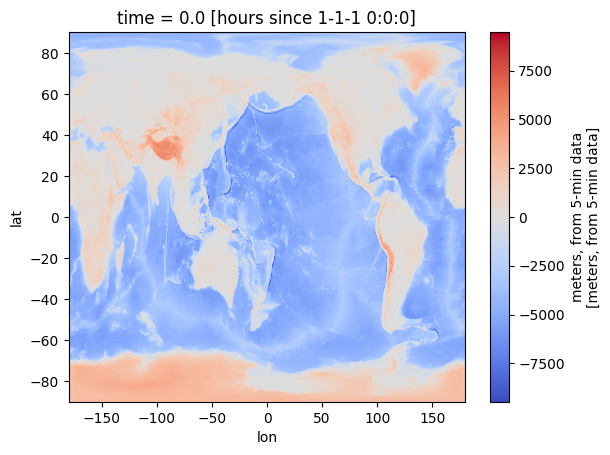

In [ ]:
el_world.data.plot(cmap=plt.cm.coolwarm)

In [ ]:
# lon -125.0 -124.8 -124.5 ... -116.5 -116.2 -116.0
# lat 49.0 48.75 48.5 48.25 ... 45.5 45.25 45.0

min_lon = -125.0
max_lon = -116.0
min_lat = 49.0
max_lat = 45.0

el_w = el_world.sel(lat=slice(min_lat, max_lat), lon=slice(min_lon, max_lon))

# goal: latitude: 17, longitude: 37
print(el_w)

<xarray.Dataset>
Dimensions:  (lat: 17, lon: 37, time: 1)
Coordinates:
  * lat      (lat) float32 49.0 48.75 48.5 48.25 48.0 ... 45.75 45.5 45.25 45.0
  * lon      (lon) float32 -125.0 -124.8 -124.5 -124.2 ... -116.5 -116.2 -116.0
  * time     (time) float64 0.0
Data variables:
    data     (time, lat, lon) float32 ...
Attributes:
    history:  \nElevations calculated from the TBASE 5-minute\nlatitude-longi...


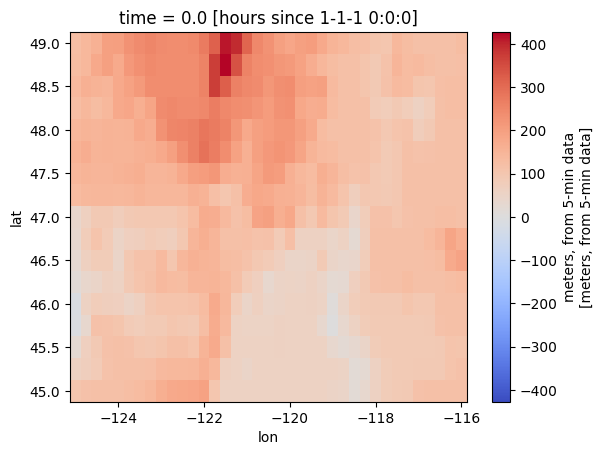

In [ ]:
el_w.data.plot(cmap = plt.cm.coolwarm)

<ipython-input-13-1774b05d316b>:15: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  cs = el_w_map.pcolor(xi, yi, np.squeeze(np.array(el_w.data.values)))


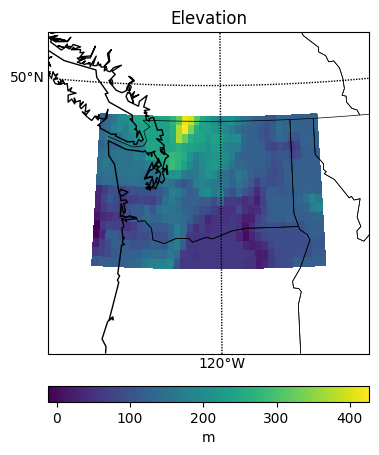

In [ ]:
# get some parameters for the stereographic projection
lon_0 = el_w.lon.mean()
lat_0 = el_w.lat.mean()

el_w_map = Basemap(width=1E6, height=1E6,
                   resolution='l', projection='stere',
                   lat_0=lat_0, lon_0=lon_0)

# because our lon and lat variables are 1D, use meshgrid to create 2D arrays
# not necessary if coordinates are already in 2D arrays.
lons, lats = np.meshgrid(el_w.lon, el_w.lat)
xi, yi = el_w_map(lons, lats)

# plot data
cs = el_w_map.pcolor(xi, yi, np.squeeze(np.array(el_w.data.values)))

# add grid lines
el_w_map.drawparallels(np.arange(-80., 81., 10.), labels=[1, 0, 0, 0], fontsize=10)
el_w_map.drawmeridians(np.arange(-180., 181., 10.), labels=[0, 0, 0, 1], fontsize=10)

# add coastlines, states, and country boundaries
el_w_map.drawcoastlines()
el_w_map.drawstates()
el_w_map.drawcountries()

# add colorbar
cbar = el_w_map.colorbar(cs, location='bottom', pad='10%')
cbar.set_label('m')

# add title
plt.title('Elevation')

plt.show()

In [ ]:
# minimum elevation value
el_w['data'].values[0].min()

-12.0

### Adding elevation data in the dataset

In [ ]:
# put all datasets into a list
datasets_to_merge = [datasets[f'Y{year}'] for year in range(2018, 2024)]

# merge datasets along the 'time' dimension
merged_ds = xr.concat(datasets_to_merge, dim='time')
merged_ds

<xarray.Dataset>
Dimensions:    (longitude: 37, latitude: 17, time: 51751)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -116.5 -116.2 -116.0
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 45.5 45.25 45.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-11-27T06:00:00
Data variables:
    u10        (time, latitude, longitude) float32 -1.931 -1.665 ... -1.248
    v10        (time, latitude, longitude) float32 -2.316 -2.033 ... 1.514 1.498
    t2m        (time, latitude, longitude) float32 274.8 273.3 ... 260.5 257.1
    cbh        (time, latitude, longitude) float32 1.073e+03 1.098e+03 ... nan
    lcc        (time, latitude, longitude) float32 0.3962 0.3922 ... 0.01666
    msl        (time, latitude, longitude) float32 1.024e+05 ... 1.031e+05
    ssr        (time, latitude, longitude) float32 2.014e+05 ... -0.125
    sp         (time, latitude, longitude) float32 9.84e+04 ... 8.154e+04
    tcc        (time, latitude, longitude) float32 0.7032 0.5895 ... 0.01666
    tp         (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 02:12:55 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [ ]:
# extract elevation values
elevation_values = el_w['data'].values[0]

# create a DataArray with constant elevation values
constant_elevation = xr.DataArray(
    elevation_values,
    dims = ('latitude', 'longitude'),
    coords = {'latitude': merged_ds['latitude'],
              'longitude': merged_ds['longitude']})

# add the elevation DataArray to the merged dataset
merged_ds['elevation'] = constant_elevation
merged_ds

<xarray.Dataset>
Dimensions:    (longitude: 37, latitude: 17, time: 51751)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -116.5 -116.2 -116.0
  * latitude   (latitude) float32 49.0 48.75 48.5 48.25 ... 45.5 45.25 45.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2023-11-27T06:00:00
Data variables:
    u10        (time, latitude, longitude) float32 -1.931 -1.665 ... -1.248
    v10        (time, latitude, longitude) float32 -2.316 -2.033 ... 1.514 1.498
    t2m        (time, latitude, longitude) float32 274.8 273.3 ... 260.5 257.1
    cbh        (time, latitude, longitude) float32 1.073e+03 1.098e+03 ... nan
    lcc        (time, latitude, longitude) float32 0.3962 0.3922 ... 0.01666
    msl        (time, latitude, longitude) float32 1.024e+05 ... 1.031e+05
    ssr        (time, latitude, longitude) float32 2.014e+05 ... -0.125
    sp         (time, latitude, longitude) float32 9.84e+04 ... 8.154e+04
    tcc        (time, latitude, longitude) float32 0.7032 0.5895 ... 0.01666
    tp         (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    elevation  (latitude, longitude) float32 124.0 142.0 158.0 ... 119.0 120.0
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-02 02:12:55 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

### merge_ds evaluation

In [ ]:
# Check if any values in arrays are nan
print(np.any(np.isnan(merged_ds)))

<xarray.Dataset>
Dimensions:    ()
Data variables:
    u10        bool False
    v10        bool False
    t2m        bool False
    cbh        bool True
    lcc        bool False
    msl        bool False
    ssr        bool False
    sp         bool False
    tcc        bool False
    tp         bool False
    elevation  bool False


In [ ]:
variables = ['u10', 'v10', 't2m', 'lcc', 'msl', 'ssr', 'tcc', 'tp', 'elevation', 'sp']

for var in variables:
    print(f'{var}', xr.corr(merged_ds[var], merged_ds['cbh']))

u10 <xarray.DataArray ()>
array(-0.09178082)
v10 <xarray.DataArray ()>
array(-0.08770908)
t2m <xarray.DataArray ()>
array(0.31043671)
lcc <xarray.DataArray ()>
array(-0.563276)
msl <xarray.DataArray ()>
array(-0.02501819)
ssr <xarray.DataArray ()>
array(0.16340466)
tcc <xarray.DataArray ()>
array(-0.10975289)
tp <xarray.DataArray ()>
array(-0.22283083)
elevation <xarray.DataArray ()>
array(-0.08758125)
sp <xarray.DataArray ()>
array(-0.063455)


In [ ]:
print(xr.corr(merged_ds['tcc'], merged_ds['ssr']))

<xarray.DataArray ()>
array(-0.21078318)


### Sequence the data (switching nan to -9999)

In [ ]:
ds = merged_ds.copy()

# convert the dataset to a numpy array
ds = merged_ds.to_array().values.transpose(1, 0, 2, 3)
ds.shape

(51751, 11, 17, 37)

In [ ]:
# switching nan to -9999
ds[np.isnan(ds)] = -9999

In [ ]:
def create_sequences(data, seq_length):
    n_sequences = data.shape[0] - seq_length

    sequences = np.array([data[i:i + seq_length] for i in range(n_sequences)])
    targets = data[seq_length:data.shape[0], 3, :, :]

    return sequences, targets

In [ ]:
# define sequence length
seq_length = 6

# create sequences
sequences, targets = create_sequences(ds, seq_length)
print(sequences.shape, targets.shape)

(51745, 6, 11, 17, 37) (51745, 17, 37)



### Splitting and normalizing data

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(sequences, targets, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(41396, 6, 11, 17, 37) (41396, 17, 37)
(5174, 6, 11, 17, 37) (5174, 17, 37)
(5175, 6, 11, 17, 37) (5175, 17, 37)


In [ ]:
# reshape
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# normalize the training set
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train_flat)

# use training set statistics to normalize the validation set
X_val_normalized = scaler.transform(X_val_flat)

# use training set statistics to normalize the test set
X_test_normalized = scaler.transform(X_test_flat)

print(X_train_normalized.shape, X_val_normalized.shape, X_test_normalized.shape)

(41396, 41514) (5174, 41514) (5175, 41514)


### Create and fit LSTM model


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:
# reshape data for LSTM model
X_train = X_train_normalized.reshape(X_train.shape[0], X_train.shape[1], -1)
y_train = y_train.reshape(y_train.shape[0], -1)

X_val = X_val_normalized.reshape(X_val.shape[0], X_val.shape[1], -1)
y_val = y_val.reshape(y_val.shape[0], -1)

X_test = X_test_normalized.reshape(X_test.shape[0], X_test.shape[1], -1)
y_test = y_test.reshape(y_test.shape)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(41396, 6, 6919) (41396, 629)
(5174, 6, 6919) (5174, 629)
(5175, 6, 6919) (5175, 17, 37)


In [ ]:
# define the input and output shapes
input_shape = (X_train.shape[1], X_train.shape[2])
output_shape = y_test.shape[1]

# create the model
model = keras.Sequential([
    LSTM(1024, input_shape=input_shape, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(512, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(512),
    Dropout(0.2),
    Dense(output_shape)
])

# compile the model
model.compile(loss='mse', optimizer='adam')

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 1024)           32538624  
                                                                 
 dropout (Dropout)           (None, 6, 1024)           0         
                                                                 
 batch_normalization (Batch  (None, 6, 1024)           4096      
 Normalization)                                                  
                                                                 
 lstm_1 (LSTM)               (None, 6, 512)            3147776   
                                                                 
 dropout_1 (Dropout)         (None, 6, 512)            0         
                                                                 
 batch_normalization_1 (Bat  (None, 6, 512)            2048      
 chNormalization)                                       

In [ ]:
# learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# model checkpoint !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# model_checkpoint = ModelCheckpoint('drive/MyDrive/Colab Notebooks/best_LSTM_b79.keras', monitor='val_loss', save_best_only=True)

In [ ]:
# fit the model
model.fit(X_train, y_train,
          epochs=500, batch_size=79,
          validation_data=(X_val, y_val),
          callbacks=[reduce_lr, early_stopping, model_checkpoint])

Epoch 1/400
1336/1336 [==============================] - 39s 23ms/step - loss: 29814172.0000 - val_loss: 21183252.0000 - lr: 0.0010
Epoch 2/400
1336/1336 [==============================] - 27s 20ms/step - loss: 27901856.0000 - val_loss: 19885750.0000 - lr: 0.0010
Epoch 3/400
1336/1336 [==============================] - 27s 20ms/step - loss: 26383674.0000 - val_loss: 19036120.0000 - lr: 0.0010
Epoch 4/400
1336/1336 [==============================] - 27s 20ms/step - loss: 25155642.0000 - val_loss: 18354990.0000 - lr: 0.0010
Epoch 5/400
1336/1336 [==============================] - 27s 20ms/step - loss: 24142592.0000 - val_loss: 18010652.0000 - lr: 0.0010
Epoch 6/400
1336/1336 [==============================] - 27s 20ms/step - loss: 23292576.0000 - val_loss: 17143860.0000 - lr: 0.0010
Epoch 7/400
1336/1336 [==============================] - 27s 20ms/step - loss: 22632354.0000 - val_loss: 16876018.0000 - lr: 0.0010
Epoch 8/400
1336/1336 [==============================] - 26s 20ms/step - los

### Create and fit ConvLSTM model


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ConvLSTM2D, Flatten, Dropout, LeakyReLU
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:
# reshape data for convLSTM model
X_train = X_train_normalized.reshape(X_train.shape)
y_train = y_train.reshape(y_train.shape[0], -1)

X_val = X_val_normalized.reshape(X_val.shape)
y_val = y_val.reshape(y_val.shape[0], -1)

X_test = X_test_normalized.reshape(X_test.shape)
y_test = y_test.reshape(y_test.shape)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(41396, 6, 11, 17, 37) (41396, 629)
(5174, 6, 11, 17, 37) (5174, 629)
(5175, 6, 11, 17, 37) (5175, 17, 37)


In [ ]:
# define the input and output shapes
input_shape = X_train.shape[1:]
output_shape = np.prod(y_test.shape[1:])

# create the model
model = Sequential([
  ConvLSTM2D(filters=11, kernel_size=(3, 3), data_format='channels_first', input_shape=input_shape, padding='same', return_sequences=True),
  LeakyReLU(),
  BatchNormalization(),
  Dropout(0.2),
  ConvLSTM2D(filters=32, kernel_size=(3, 3), data_format='channels_first', padding='same', return_sequences=True),
  LeakyReLU(),
  BatchNormalization(),
  Dropout(0.2),
  ConvLSTM2D(filters=64, kernel_size=(3, 3), data_format='channels_first', padding='same', return_sequences=True),
  LeakyReLU(),
  BatchNormalization(),
  Dropout(0.2),
  ConvLSTM2D(filters=16, kernel_size=(3, 3), data_format='channels_first', padding='same', return_sequences=True),
  LeakyReLU(),
  BatchNormalization(),
  Dropout(0.2),
  ConvLSTM2D(filters=1, kernel_size=(3, 3), data_format='channels_first', padding='same', return_sequences=False),
  Flatten(),
  Dense(128),
  LeakyReLU(),
  Dropout(0.2),
  Dense(64),
  LeakyReLU(),
  Dropout(0.2),
  Dense(output_shape)
])

# compile the model
model.compile(loss='mse', optimizer='adam')

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 6, 11, 17, 37)     8756      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6, 11, 17, 37)     0         
                                                                 
 batch_normalization (Batch  (None, 6, 11, 17, 37)     148       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 6, 11, 17, 37)     0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 6, 32, 17, 37)     49664     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6, 32, 17, 37)     0         
                                                        

In [ ]:
# learning rate schedule
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001)

# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# model checkpoint !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# model_checkpoint = ModelCheckpoint('drive/MyDrive/Colab Notebooks/best_convLSTM_reduced_b131_withoutLR23425.keras', monitor='val_loss', save_best_only=True)

In [ ]:
# fit the model
model.fit(X_train,
          y_train,
          epochs = 500,
          batch_size = 131,
          validation_data = (X_val, y_val),
          callbacks=[reduce_lr, early_stopping, model_checkpoint])


Epoch 1/500


KeyboardInterrupt: 

### Save or load a model

In [ ]:
import tensorflow as tf

In [ ]:
# save the entire model as a `.keras` zip archive.
# model.save('drive/MyDrive/Colab Notebooks/best_LSTM_b79.keras')

In [ ]:
# load the saved model
model = tf.keras.models.load_model('drive/MyDrive/Colab Notebooks/best_convLSTM_reduced_b79_withRL.keras')

# show the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 6, 11, 17, 37)     8756      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6, 11, 17, 37)     0         
                                                                 
 batch_normalization (Batch  (None, 6, 11, 17, 37)     148       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 6, 11, 17, 37)     0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 6, 32, 17, 37)     49664     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 6, 32, 17, 37)     0         
                                                        

###Visual test

In [ ]:
# get elevation array
el_arr = ds[0, 10].copy()
print(el_arr.shape, np.min(el_arr))

(17, 37) -12.0


In [ ]:
# shifting to show 4 previous stages, but not to go over the array's length
# 1st element in prediction is 4, and the max last is last elem in the data
pred_num = 10
dev = (X_test.shape[0] - 5) // pred_num
print(dev)

517


In [ ]:
# predict pred_num equaly distributed cbh maps
predictions = np.array([model.predict(X_test[[dev * i + 4]]) for i in range(pred_num)])
print(predictions.shape)

1/1 [==============================] - 0s 54ms/step
(10, 1, 629)


In [ ]:
# reshaping predictions from (pred_num, 1, 629) to (pred_num, 17, 37)
predictions = np.array([predictions[i, 0, 0:629].reshape(17, 37) for i in range(pred_num)])
print(predictions.shape)

In [ ]:
# create an array with 5 real cbh and 1 predicted cbh
# shape = (pred_num, 5+1, latitude, longitude)
combined_array = np.empty((0, 6, 17, 37))

for i in range(pred_num):
  n = i * dev

  lol = np.concatenate((y_test[n:n+5], predictions[[i]]), axis=0)
  combined_array = np.concatenate((combined_array, [lol]), axis=0)

  print(i, n, combined_array.shape)

0 0 (1, 6, 17, 37)
1 517 (2, 6, 17, 37)
2 1034 (3, 6, 17, 37)
3 1551 (4, 6, 17, 37)
4 2068 (5, 6, 17, 37)
5 2585 (6, 6, 17, 37)
6 3102 (7, 6, 17, 37)
7 3619 (8, 6, 17, 37)
8 4136 (9, 6, 17, 37)
9 4653 (10, 6, 17, 37)


-12.0 10887.62109375


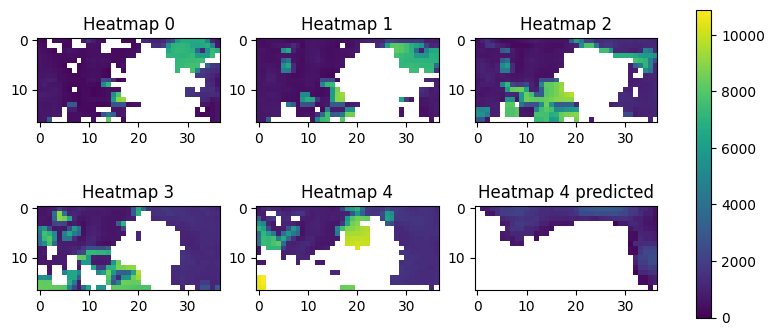

-12.0 10983.5986328125


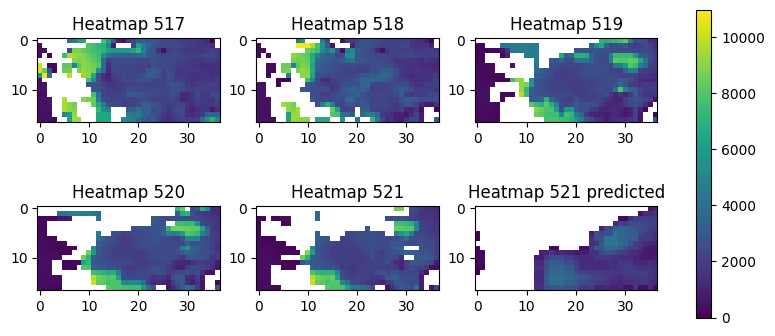

-12.0 11005.224609375


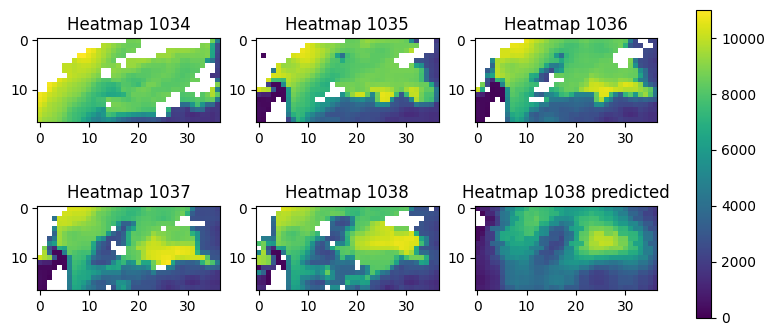

-12.0 10062.3349609375


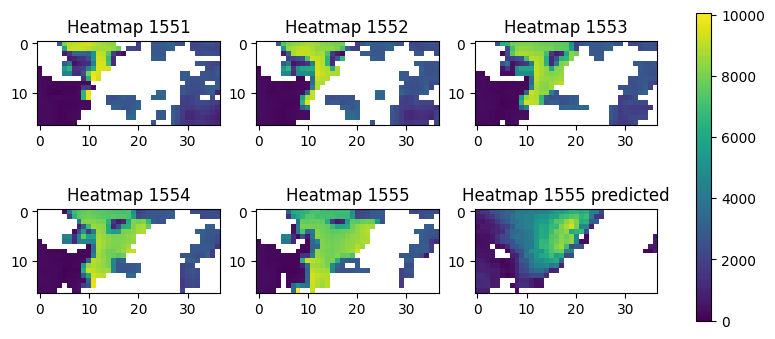

-12.0 11576.1484375


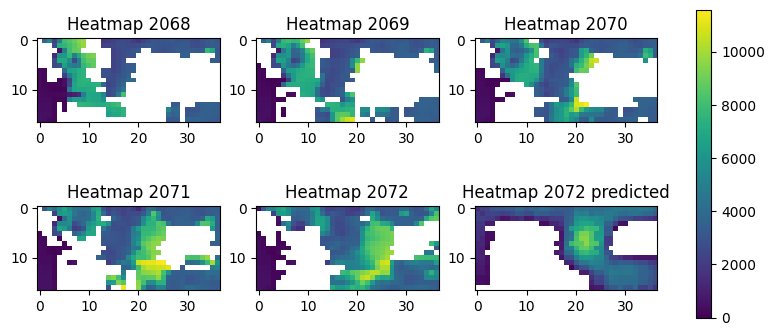

-12.0 8281.5947265625


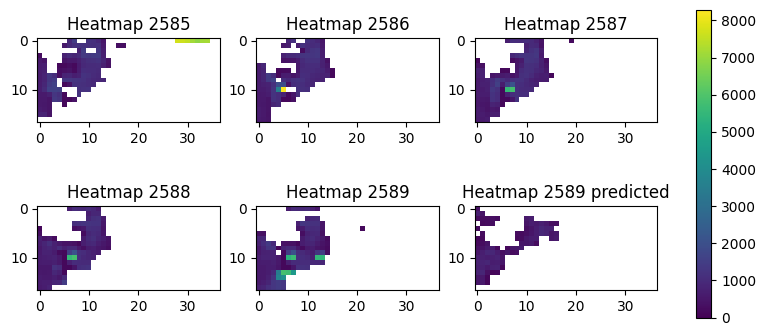

-12.0 12362.7138671875


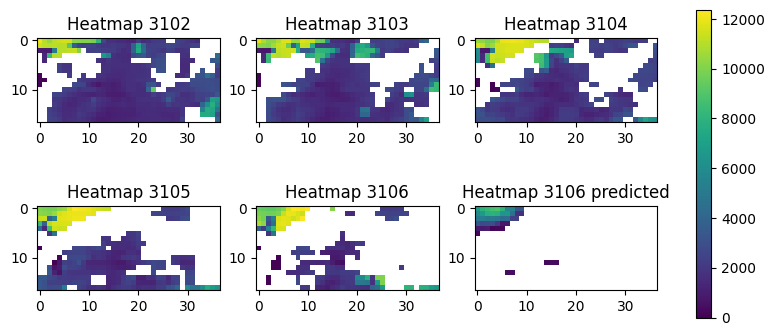

-12.0 8421.4423828125


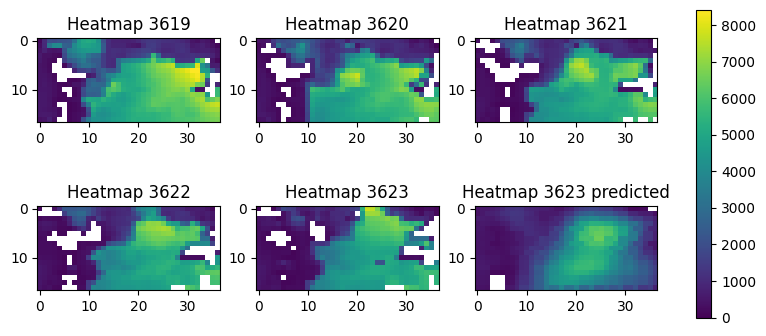

-12.0 5044.9169921875


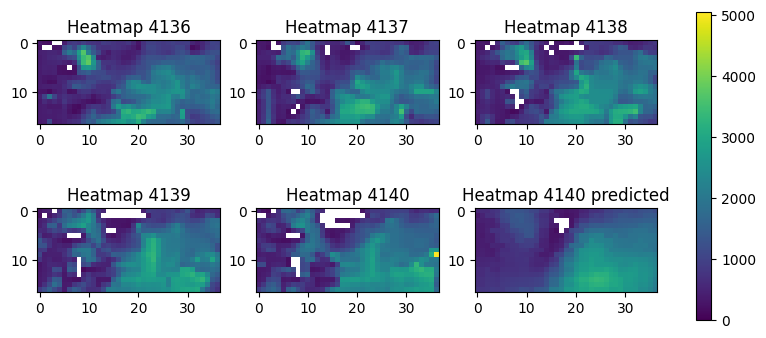

-12.0 4899.919921875


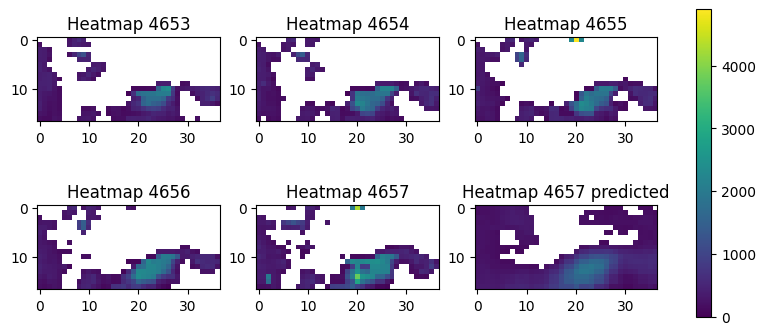

In [ ]:
# plot pred_num arrays (heatmaps)
for k in range(pred_num):
  n = k * dev

  vmin = np.min(el_arr)
  vmax = np.max(combined_array[k])
  print(vmin, vmax)

  # assign nan for clouds 'below' ground level (clear sky)
  combined_array[k][combined_array[k] <= el_arr] = np.nan

  fig, axes = plt.subplots(2, 3, figsize = (10, 4))

  for i, ax in enumerate(axes.flat):
      data = combined_array[k, i]

      # create the heatmap using imshow()
      im = ax.imshow(data, cmap='viridis', vmin = vmin, vmax = vmax)

      # add colorbar for individual visual reference
      # fig.colorbar(im, ax=ax)

      # name plot
      if i < 5:
        ax.set_title(f"Heatmap {n+i}")
      else:
        ax.set_title(f"Heatmap {n+i-1} predicted")

  # add colorbar for all visual references
  fig.colorbar(im, ax=axes.ravel().tolist())
  plt.show()

###MAE test

In [ ]:
from tensorflow.keras.losses import MeanAbsoluteError

In [ ]:
# shifting on 1 to not go over array's length
mae_pred_num = 100
mae_dev = (X_test.shape[0] - 1) // mae_pred_num
print(mae_dev)

51


In [ ]:
# predict mae_pred_num equaly distributed cbh maps
mae_predictions = np.array([model.predict(X_test[[mae_dev * i]]) for i in range(mae_pred_num)])
print(mae_predictions.shape)

1/1 [==============================] - 0s 55ms/step
(100, 1, 629)


In [ ]:
# reshape predictions from (mae_pred_num, 1, 629) to (mae_pred_num, 17, 37)
mae_predictions = np.array([mae_predictions[i, 0, 0:629].reshape(17, 37) for i in range(mae_pred_num)])
print(mae_predictions.shape)

(100, 17, 37)


In [ ]:
# get mae_pred_num of ground truth data
mae_y_test = np.array([y_test[mae_dev * i] for i in range(mae_pred_num)])
print(mae_y_test.shape)

(100, 17, 37)


In [ ]:
# assign 0 for clouds 'below' ground level (clear sky)
mae_predictions[mae_predictions <= el_arr] = 0
mae_y_test[mae_y_test <= el_arr] = 0

In [ ]:
# calculate mean absolute error
mae = MeanAbsoluteError()
loss = mae(mae_y_test, mae_predictions).numpy()
print(loss)

818.9148


# Results


best_convLSTM_reduced_b79_withRL:
*   Features: 11
*   Val_eror: 7286526
*   MAE error: 818.9
*   Epochs: 209
*   Time: 73s

best_convLSTM_reduced_b79_withoutLR:
*   Features: 11
*   Val_eror: 8051711.5
*   MAE error: 872.4
*   Epochs: 164
*   Time: 73s

best_convLSTM_reduced_b131_withLR:
*   Features: 11
*   Val_eror: 7535766
*   MAE error: 826.7
*   Epochs: 187
*   Time: 66s

best_convLSTM_reduced_b131_withoutLR:
*   Features: 11
*   Val_eror: 8716309
*   MAE error: 942.0
*   Epochs: 64
*   Time: 66s

best_LSTM_b79:
*   Features: 11
*   Val_eror: 15593996
*   MAE error: 1378.3
*   Epochs: 38
*   Time: 24s






### Future work:
*   Add middle and top cloud coverage features
*   Add temporal features (e.g. hour of a day)
*   Increase the dataset by adding more years
*   Play with hyperparameters
*   Pay more attention for low cloud base height (about 100m)
*   Try to make 2 models (classification + regression)
*   Try a transformer model
*   Do something with 'resolution'


